In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the datasets
sales_df = pd.read_csv('sales data-set.csv')
features_df = pd.read_csv('Features data set.csv')
stores_df = pd.read_csv('stores data-set.csv')

# Merge the datasets
# Step 1: Merge sales and features on Store, Date, and IsHoliday
merged_df = pd.merge(sales_df, features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

# Step 2: Merge the result with stores data on Store
final_df = pd.merge(merged_df, stores_df, on='Store', how='left')

# Convert 'Date' column to datetime objects
final_df['Date'] = pd.to_datetime(final_df['Date'], format='%d/%m/%Y')

print("Data successfully loaded and merged.")
print(f"Shape of the final dataset: {final_df.shape}")
print("\nFirst 5 rows of the combined data:")
final_df.head()

Data successfully loaded and merged.
Shape of the final dataset: (421570, 16)

First 5 rows of the combined data:


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


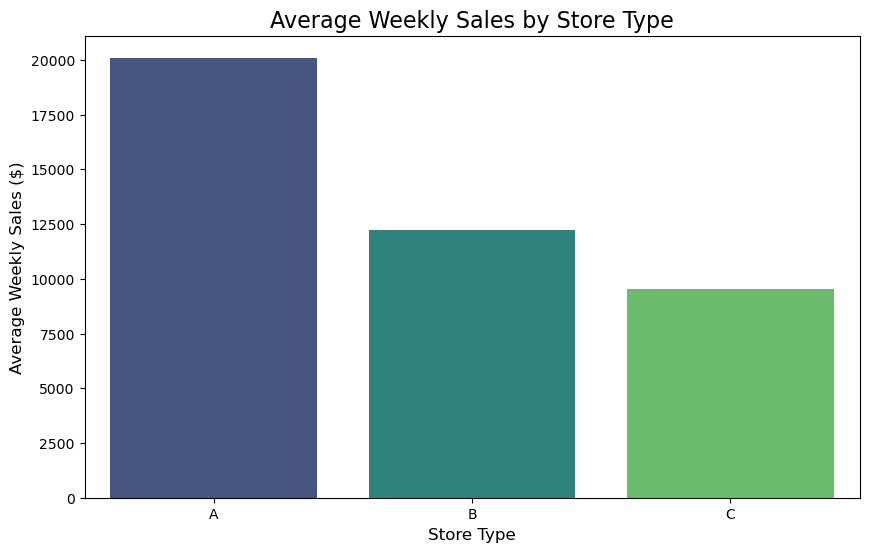

In [2]:
# EDA
# Group by store type and calculate the mean weekly sales
sales_by_type = final_df.groupby('Type')['Weekly_Sales'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
# sns.barplot(x=sales_by_type.index, y=sales_by_type.values, palette='viridis')
sns.barplot(
    x=sales_by_type.index,
    y=sales_by_type.values,
    hue=sales_by_type.index,     # Explicitly assign hue
    palette='viridis',
    legend=False                 # Optional: hides legend
)


plt.title('Average Weekly Sales by Store Type', fontsize=16)
plt.xlabel('Store Type', fontsize=12)
plt.ylabel('Average Weekly Sales ($)', fontsize=12)
plt.show()

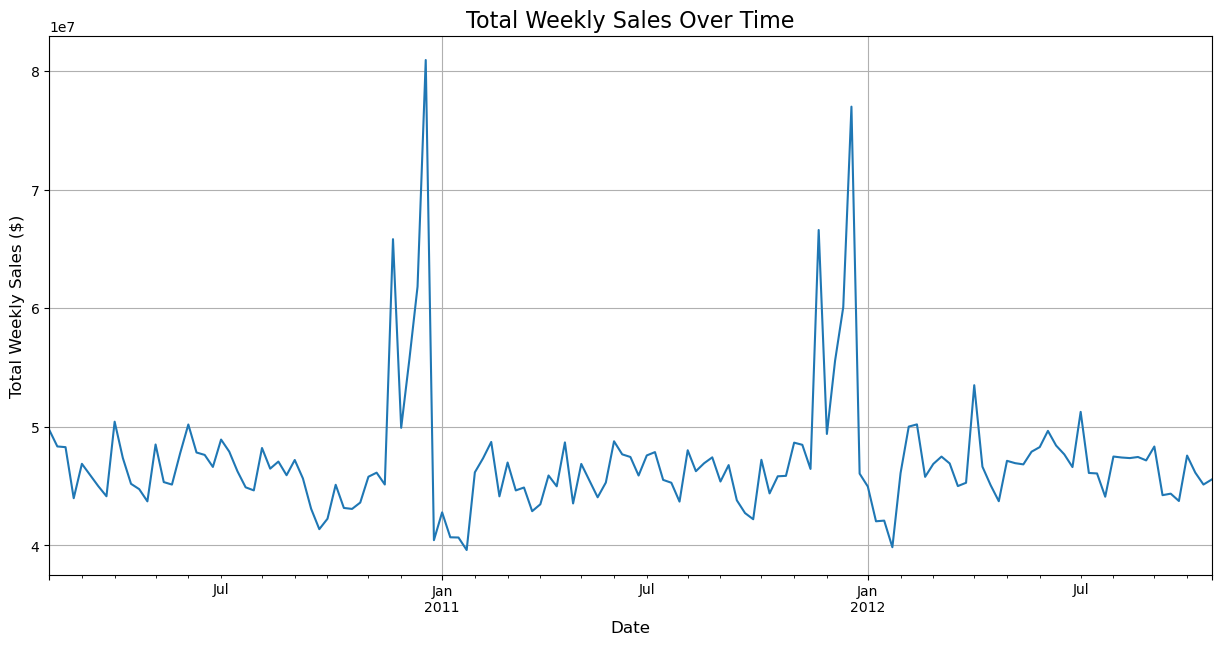

In [3]:
# Aggregate sales by date
sales_over_time = final_df.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(15, 7))
sales_over_time.plot()
plt.title('Total Weekly Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Weekly Sales ($)', fontsize=12)
plt.grid(True)
plt.show()

In [4]:
# Feature Engineering from Date
final_df['Year'] = final_df['Date'].dt.year
final_df['Month'] = final_df['Date'].dt.month
final_df['WeekOfYear'] = final_df['Date'].dt.isocalendar().week

# Handle Missing Values (filling MarkDown NaNs with 0)
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    final_df[col] = final_df[col].fillna(0)
    
# One-hot encode the 'Type' column
final_df = pd.get_dummies(final_df, columns=['Type'], drop_first=True)

# Convert boolean 'IsHoliday' to integer (1 for True, 0 for False)
final_df['IsHoliday'] = final_df['IsHoliday'].astype(int)

print("Feature engineering and preprocessing complete.")
final_df.head()

Feature engineering and preprocessing complete.


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Month,WeekOfYear,Type_B,Type_C
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,2010,2,5,False,False
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,151315,2010,2,6,False,False
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,151315,2010,2,7,False,False
3,1,1,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,151315,2010,2,8,False,False
4,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,151315,2010,3,9,False,False


In [5]:
# Define features (X) and target (y)
features = [col for col in final_df.columns if col not in ['Weekly_Sales', 'Date']]
X = final_df[features]
y = final_df['Weekly_Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor model
# We use n_estimators=50 for speed and n_jobs=-1 to use all available CPU cores
print("Training the Random Forest model... (This may take a moment)")
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=20, min_samples_leaf=2)
rf_model.fit(X_train, y_train)
print("Model training complete.")

Training the Random Forest model... (This may take a moment)
Model training complete.


Model Performance on Test Data:
-------------------------------
R-squared (R²): 0.9727
Root Mean Squared Error (RMSE): $3776.48


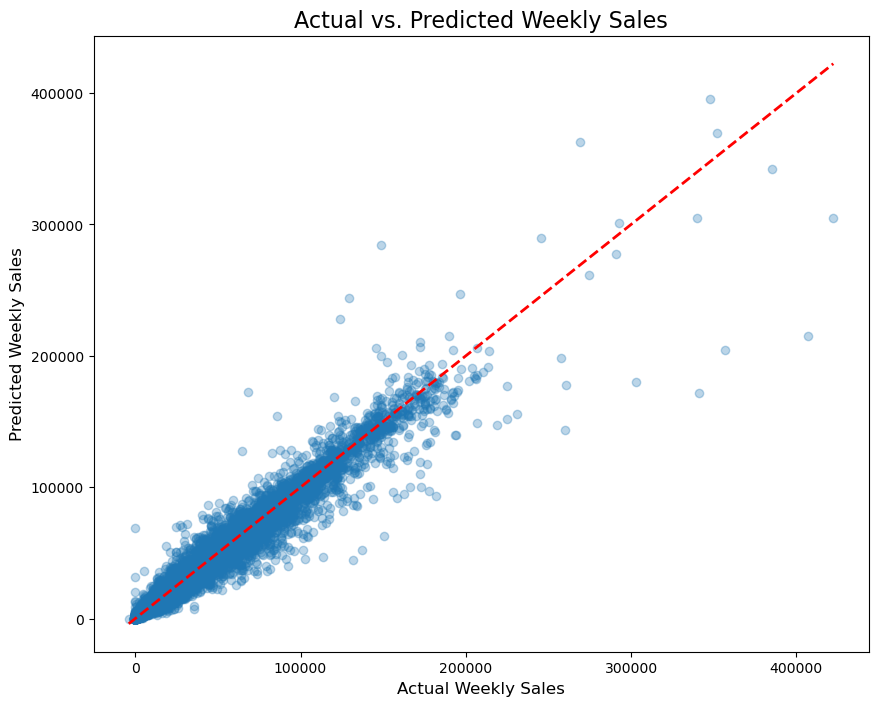

In [6]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance on Test Data:")
print("-------------------------------")
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

# Visualize actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Weekly Sales', fontsize=12)
plt.ylabel('Predicted Weekly Sales', fontsize=12)
plt.title('Actual vs. Predicted Weekly Sales', fontsize=16)
plt.show()

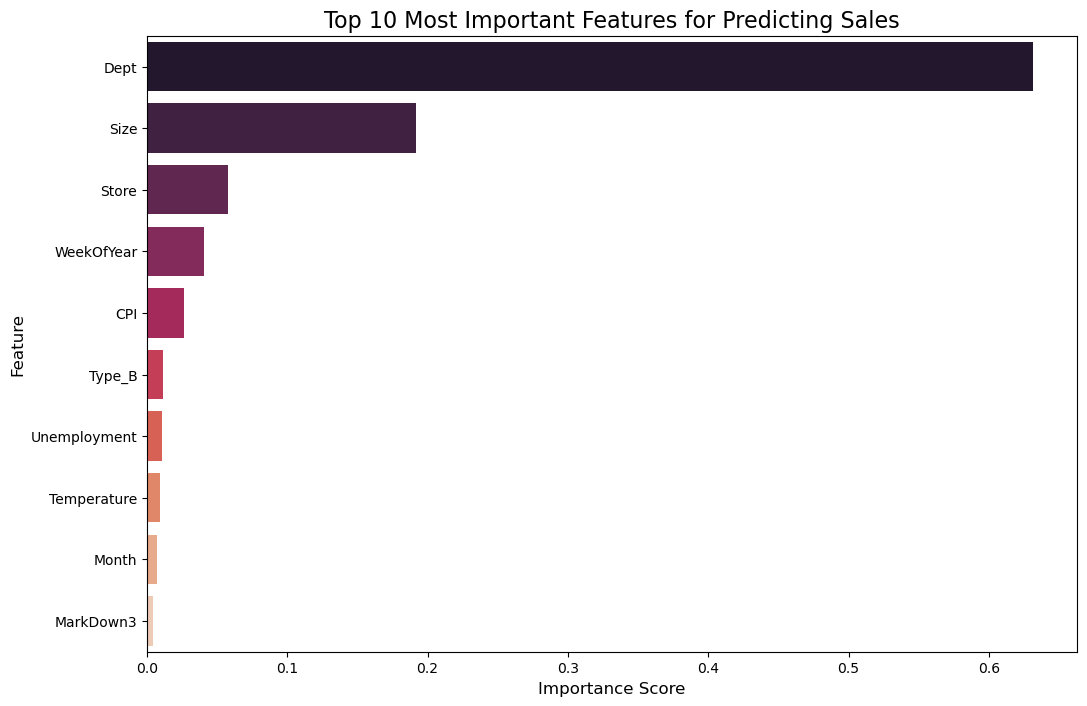

In [7]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort by importance and get the top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='rocket', hue='Feature', legend=False)
plt.title('Top 10 Most Important Features for Predicting Sales', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()